In [1]:
import os
import cv2
import glob
from math import ceil, floor
import numpy as np
import rasterio
from rasterio.mask import mask

from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from pyproj import Proj, transform
from scipy import ndimage


%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils')
from dataloaders import stretch_8bit

In [261]:
b01 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B01.tif')
b02 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B02.tif')
b03 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B03.tif')
b04 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B04.tif')

In [269]:
b01_d = b01.read()[0]
b02_d = b02.read()[0]
b03_d = b03.read()[0]
b04_d = b04.read()[0]

In [263]:
s2b01 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B01.jp2')
s2b02 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B02.jp2')
s2b03 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B03.jp2')
s2b04 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B04.jp2')


In [264]:
s2b01_d = s2b01.read()[0]
s2b02_d = s2b02.read()[0]
s2b03_d = s2b03.read()[0]
s2b04_d = s2b04.read()[0]

In [265]:
b02.crs, s2b02.crs

(CRS({'init': 'epsg:4326'}), CRS({'init': 'epsg:32639'}))

In [266]:
b02.affine, s2b02.affine

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(Affine(9.40310727259156e-05, 0.0, 54.540252685546875,
        0.0, -9.396766865970705e-05, 24.366488081551143),
 Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 2700000.0))

In [285]:
"""b02.affine = (Affine(9.40310727259156e-05, 0.0, 54.540252685546875,
        0.0, -9.396766865970705e-05, 24.366488081551143),
 s2b02.affine = Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 2700000.0))"""

a = b01.affine
s2a = s2b01.affine
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:32639', preserve_units=True)

def get_pix_from_s2(x, y):
    x1,y1 = a * (x,y)
    x2, y2 = transform(inProj,outProj,x1,y1)
    return  ~s2a * (x2,y2)


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [286]:
x0, y0 = get_pix_from_s2(0,0)
xn, yn = get_pix_from_s2(b01_sthd.shape[0], b01_sthd.shape[1])
print (xn,x0, yn,y0)
print (b01_sthd.shape)
print (s2b01_sthd.shape)

1117.5249969552842 987.1270190639261 143.6165902760331 10.244934206901235
(133, 131)
(1830, 1830)


In [271]:
b01_sthd = stretch_8bit(b01_d, 2, 98)
s2b01_sthd = stretch_8bit(s2b01_d, 2, 98)

In [12]:
rgb = cv2.merge([stretch_8bit(b02_d),stretch_8bit(b03_d),stretch_8bit(b04_d)])
s2rgb = cv2.merge([stretch_8bit(s2b02_d),stretch_8bit(s2b03_d),stretch_8bit(s2b04_d)])

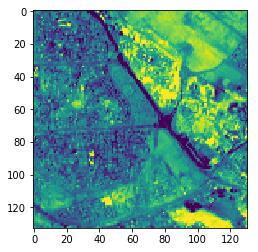

In [272]:
plt.imshow(b01_sthd)

In [287]:
out = np.zeros((b01_sthd.shape[0],b01_sthd.shape[1]))

for i in range(b01_sthd.shape[0]):
    for j in range(b01_sthd.shape[1]):
        x,y = get_pix_from_s2(b01_sthd.shape[1]-j,b01_sthd.shape[0]-i)
        out[i,j] = s2b01_sthd[int(round(y)),int(round(x))]


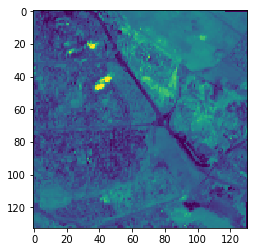

In [288]:
out = ndimage.rotate(out.astype(np.uint8), 180)
plt.imshow(out)

In [260]:
cv2.imwrite('reprojected.png',out)

True

In [167]:
get_pix_from_s2(0,0), get_pix_from_s2(799, 785)

((5922.762114383571, 61.469605241378304),
 (6707.021799902621, 859.581608729146))

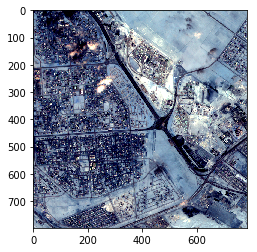

In [169]:
plt.imshow(s2rgb[61:859,5922:6707,:])

In [2]:
data_path = '../../datasets/onera/images/'
cities = os.listdir(data_path)

In [4]:
for city in ['beihai', 'chongqing', 'milano']:
    if 'txt' not in city:
        dates = os.listdir(data_path + city + '/cropped_safes/')
#         os.mkdir(data_path + city + '/pngs/')
        for date in dates:
            if 'ipynb' not in date:
                b02_r = rasterio.open(data_path + city + '/cropped_safes/' + date + '/B02.tif')
                b03_r = rasterio.open(data_path + city + '/cropped_safes/' + date + '/B03.tif')
                b04_r = rasterio.open(data_path + city + '/cropped_safes/' + date + '/B04.tif')

                b02 = b02_r.read()[0]
                b03 = b03_r.read()[0]
                b04 = b04_r.read()[0]

                if np.sum(b02) != 0:
                    rgb = cv2.merge([stretch_8bit(b02), stretch_8bit(b03), stretch_8bit(b04)])
                else:
                    rgb = cv2.merge([b02, b03, b04])

                cv2.imwrite(data_path + city + '/pngs/' + date[:-4] + 'png', rgb.astype(np.uint8))

In [32]:
import csv
import os
import glob
import shutil
import json

In [30]:
data_path = '../../datasets/onera/images/'
fin = open(data_path + 'onera_multidate_metadata.txt','r')
r = csv.reader(fin, delimiter=' ')

city_map = {}
for row in r:
    city = row[0]
    
    i = 0 
    city_map[city] = {i:data_path+city+'/imgs_1'}
    i += 1
    for d in row[2:-1]:
        safe_name = glob.glob(data_path + city + '/cropped_safes/*C_' + d + '*.SAFE')[-1]
#         shutil.copytree(safe_name, data_path + city + '/imgs_mid_' + str(i))
        city_map[city][i] = safe_name
        i += 1
    city_map[city][i] = data_path+city+'/imgs_2'

In [35]:
fout = open('../../datasets/onera/multidate_metadata.json','w')
json.dump(city_map, fout)
fout.close()